# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_initial_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 8  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 20000 # Example number of data points
iterations_exp_initial = 1000 # Iterations for initial training phase
iterations_exp_long = 100000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 128     # number of hidden units
layers = 4      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(x_points): # x_points is N x dim
    """
    Computes the target function psi(x) = ||x||_2^2 for the given problem.
    """
    return euclid_norm_sq(x_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)



def evaluate_learned_J_HJ_approx(x_points, model):
    """
    Evaluates the learned prior J(x) using the method of characteristics
    for quadratic Hamiltonian H(p) = 0.5 * ||p||^2.
    
    The method of characteristics gives us:
    J(grad_psi(x)) = <x, grad_psi(x)> - 0.5 * ||grad_psi(x)||^2 - psi(x)
    
    To get J(x), we need to find the x' such that grad_psi(x') = x,
    then evaluate the formula at x'.
    
    For this specific problem where psi(x) = ||x||^2, we have grad_psi(x) = 2x,
    so to evaluate J(y), we need x = y/2.
    
    Args:
        x_points: numpy array of shape (N, dim) containing evaluation points
        model: trained LPN model
    
    Returns:
        J_est: numpy array of shape (N,) containing estimated J values
    """
    # To evaluate J(x), we need to find x' such that grad_psi(x') = x
    # For the learned psi approximating ||x||^2, grad_psi(x) ≈ 2x
    # So x' ≈ x/2 to get grad_psi(x') ≈ x
    
    # However, for a general learned model, we'd need to solve the inverse problem
    # For simplicity, assuming the model learned psi(x) ≈ ||x||^2 well,
    # we use the approximation x' = x/2
    
    x_prime = x_points / 2.0
    
    # Convert to tensor
    x_tensor = torch.from_numpy(x_prime).float().to(device)
    x_tensor.requires_grad_(True)
    
    # Get psi(x')
    psi_x = model.scalar(x_tensor)
    
    # Get gradient of psi at x'
    grad_psi = model(x_tensor)
    
    # Compute inner product <x', grad_psi(x')>
    inner_prod = torch.sum(x_tensor * grad_psi, dim=1, keepdim=True)
    
    # Compute ||grad_psi(x')||^2
    grad_psi_norm_sq = torch.sum(grad_psi * grad_psi, dim=1, keepdim=True)
    
    # Apply the formula: this gives J(grad_psi(x')) ≈ J(x)
    J_est = inner_prod - 0.5 * grad_psi_norm_sq - psi_x
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_psi_true = x1_0_psi_true
        x2_0_J_true = x1_0_J_true

    x1_0_psi_est = cvx(x1_0_points, model)
    x1_0_J_est = evaluate_learned_J_HJ_approx(x1_0_points, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        x2_0_J_est = evaluate_learned_J_HJ_approx(x2_0_points, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
    print(x1_0_J_est.shape)
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\psi$ for $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"$\psi(x_1,0,...)$ - Dim {dim}, Concave Prior")
    plt.xlabel('$x_1$')
    plt.ylabel('$\psi(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\psi$ for $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"$\psi(0,x_2,0,...)$ - Dim {dim}, Concave Prior")
        plt.xlabel('$x_2$')
        plt.ylabel('$\psi(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned J)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, Concave Prior")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned J)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, Concave Prior")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)


<>:121: SyntaxWarning: invalid escape sequence '\p'
<>:122: SyntaxWarning: invalid escape sequence '\p'
<>:124: SyntaxWarning: invalid escape sequence '\p'
<>:126: SyntaxWarning: invalid escape sequence '\p'
<>:131: SyntaxWarning: invalid escape sequence '\p'
<>:132: SyntaxWarning: invalid escape sequence '\p'
<>:134: SyntaxWarning: invalid escape sequence '\p'
<>:136: SyntaxWarning: invalid escape sequence '\p'
<>:121: SyntaxWarning: invalid escape sequence '\p'
<>:122: SyntaxWarning: invalid escape sequence '\p'
<>:124: SyntaxWarning: invalid escape sequence '\p'
<>:126: SyntaxWarning: invalid escape sequence '\p'
<>:131: SyntaxWarning: invalid escape sequence '\p'
<>:132: SyntaxWarning: invalid escape sequence '\p'
<>:134: SyntaxWarning: invalid escape sequence '\p'
<>:136: SyntaxWarning: invalid escape sequence '\p'
/scratch/16122989/ipykernel_463340/3280289920.py:121: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")


In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
x_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(x_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

x_j_exp_tensor = torch.from_numpy(x_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: x_j_exp_tensor shape {x_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
x_j_exp_tensor = x_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: x_j_exp_tensor shape torch.Size([20000, 8]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad, optimizer_concave_quad, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_concave_quad, optimizer_concave_quad, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 2000.061767578125


iteration 0 loss 47.805458068847656


iteration 5000 loss 1.6591589450836182


iteration 10000 loss 0.09162067621946335


iteration 15000 loss 0.045752495527267456


iteration 20000 loss 0.0325290709733963


iteration 25000 loss 0.025977473706007004


iteration 30000 loss 0.022032110020518303


iteration 35000 loss 0.033983081579208374


iteration 40000 loss 0.017363861203193665


iteration 45000 loss 0.015827586874365807


iteration 50000 loss 0.014562414027750492


iteration 55000 loss 0.01351913996040821


iteration 60000 loss 0.013124741613864899


iteration 65000 loss 0.012039692141115665


iteration 70000 loss 0.011400987394154072


iteration 75000 loss 0.010865658521652222


iteration 80000 loss 0.010374012403190136


iteration 85000 loss 0.009938741102814674


iteration 90000 loss 0.00953124463558197


iteration 95000 loss 0.009143386967480183


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=8) ---
(50,)


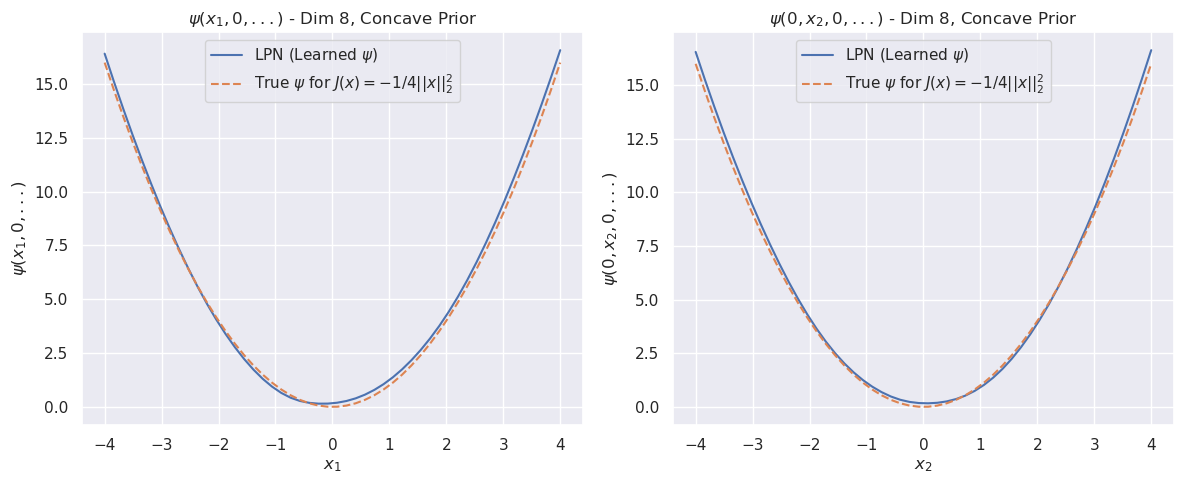

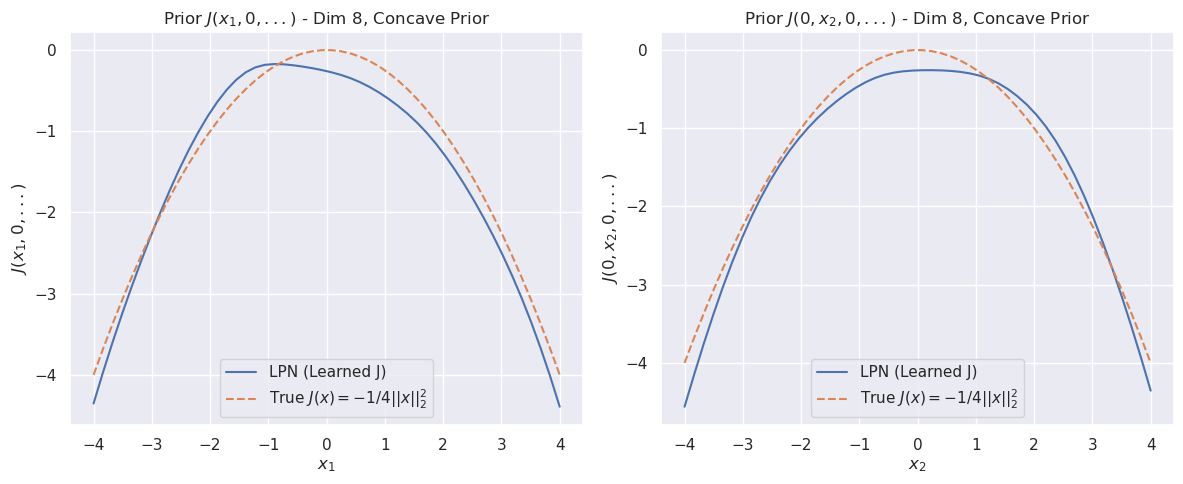

In [8]:
# --- Plot the results of the new experiment ---
plot_all_concave_quad(lpn_model_concave_quad, a_exp, spacing, INVERT_MODE, dim_exp)
#evaluate_learned_H(lpn_model_concave_quad, a_exp, spacing, dim_exp)

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Plotting Updated Prior j_hat(y) (Dim=8) ---


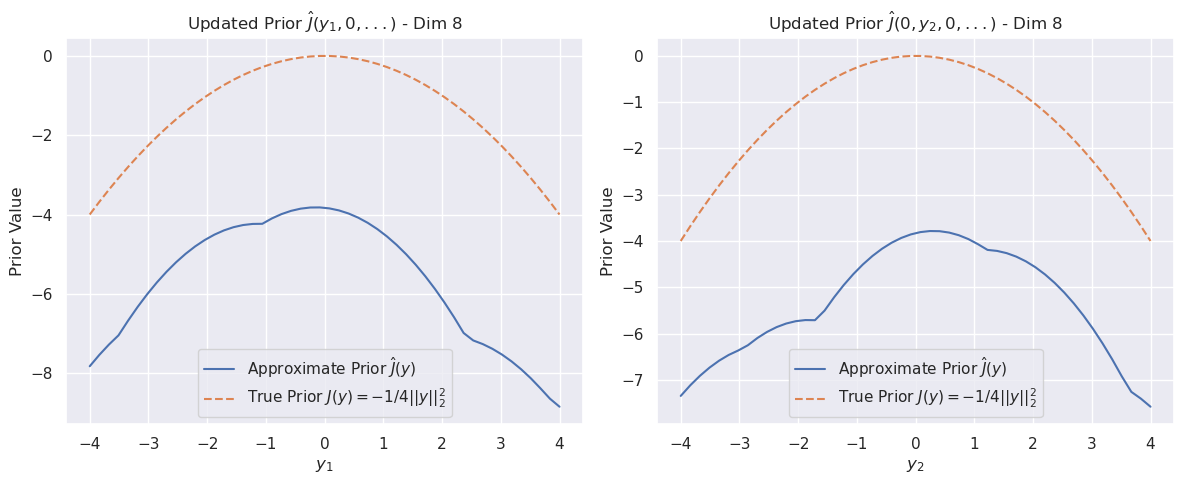

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = x_j_exp_tensor.clone()
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach() 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
    """
    Implements the approximate prior.
    """
    
    # Pre-compute y_k = grad psi(x_k) from the training data
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    y_k_tensor = model(x_k_tensor)
    y_k_np = y_k_tensor.detach().cpu().numpy()
    
    # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
    S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
    S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
    # The constant term simplifies to just S(x_k, 1)
    # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
    #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
    #        = S(x_k, 1)
    constants_k = S_x_k_np  # Shape (K,)
    
    # Term 3: -1/2 * ||x_k - y||^2
    # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
    term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
    # Term 4: 1/4 * ||y - y_k||^2
    # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
    term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

    term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
    all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
    # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
    # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
    # Take the max over K dimension
    j_hat_est = np.max(all_terms, axis=0)
    
    return j_hat_est

def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
    """
    Generates cross-section plots for the prior j_hat(y) from the "Update".
    """
    print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
    xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute true prior J(y)
    y1_0_J_true = prior_true_concave_quad(y1_0_points)
    
    # Compute estimated prior j_hat(y)
    y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
    plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
    plt.grid(True)
    plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
    plt.xlabel('$y_1$')
    plt.ylabel('Prior Value')
    plt.legend()

    if dim > 1:
        y2_0_J_true = prior_true_concave_quad(y2_0_points)
        y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
        plt.subplot(1, 2, 2)
        plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
        plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
        plt.grid(True)
        plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
        plt.xlabel('$y_2$')
        plt.ylabel('Prior Value')
        plt.legend()
        
    plt.tight_layout()
    plt.show()


# We use the original training data 'x_j_exp_np' as our set of x_k points.
#subset_size = 1000 
x_k_subset_np = x_j_exp_np#[:subset_size, :]

plot_updated_prior_J_hat(lpn_model_concave_quad, a_exp, spacing, dim_exp, x_k_subset_np)


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1967.434326171875


iteration 0 loss 46.0992317199707


iteration 5000 loss 38.90264129638672


iteration 10000 loss 0.5993390679359436


iteration 15000 loss 0.08299540728330612


iteration 20000 loss 0.04986331984400749


iteration 25000 loss 0.038932543247938156


iteration 30000 loss 0.032615918666124344


iteration 35000 loss 0.02862260676920414


iteration 40000 loss 0.02588648535311222


iteration 45000 loss 0.023676570504903793


iteration 50000 loss 0.02189585566520691


iteration 55000 loss 0.02058626525104046


iteration 60000 loss 0.01947551593184471


iteration 65000 loss 0.01846115104854107


iteration 70000 loss 0.017490407451987267


iteration 75000 loss 0.016751781105995178


iteration 80000 loss 0.01616615056991577


iteration 85000 loss 0.01558260153979063


iteration 90000 loss 0.01498420536518097


iteration 95000 loss 0.014475858770310879


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from G(x) Network ---


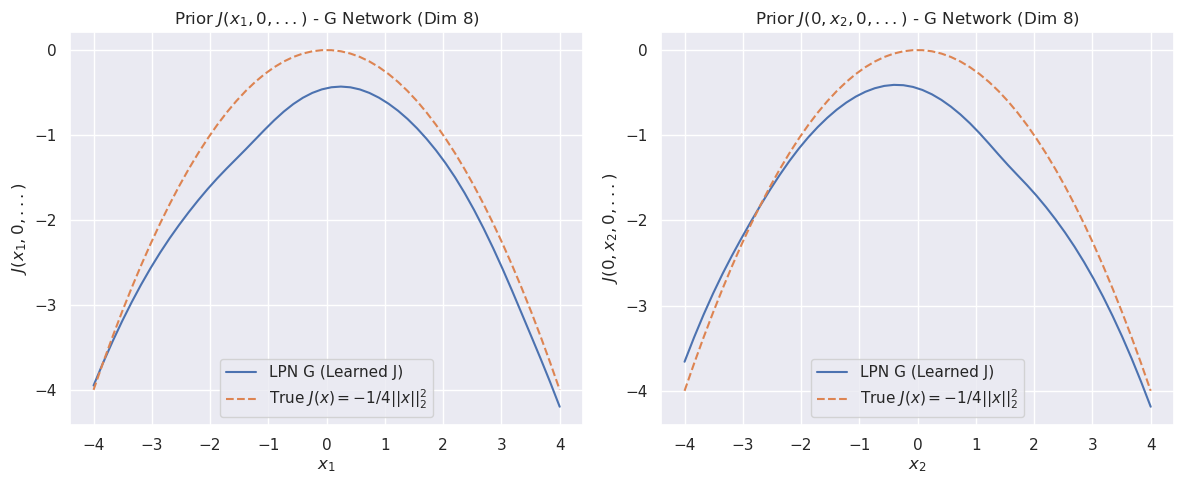

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from G(x) Network ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN G (Learned J)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - G Network (Dim {dim})")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN G (Learned J)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - G Network (Dim {dim})")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)

L1 loss -- Train

In [12]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad_l1 = torch.optim.Adam(lpn_model_concave_quad_l1.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=1, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad_l1.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=1, gamma_loss=None)

torch.save(lpn_model_concave_quad_l1.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l1.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---
iteration 0 loss 43.02925491333008


iteration 0 loss 5.240420818328857


iteration 5000 loss 0.22890155017375946


iteration 10000 loss 0.17772190272808075


iteration 15000 loss 0.1534825563430786


iteration 20000 loss 0.13954252004623413


iteration 25000 loss 0.1263897866010666


iteration 30000 loss 0.11871606111526489


iteration 35000 loss 0.11473178118467331


iteration 40000 loss 0.11451850086450577


iteration 45000 loss 0.11230762302875519


iteration 50000 loss 0.10987846553325653


iteration 55000 loss 0.09809257835149765


iteration 60000 loss 0.09450586885213852


iteration 65000 loss 0.09672252088785172


iteration 70000 loss 0.08930718153715134


iteration 75000 loss 0.08710571378469467


iteration 80000 loss 0.09700333327054977


iteration 85000 loss 0.09399211406707764


iteration 90000 loss 0.08686009794473648


iteration 95000 loss 0.08027508109807968


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=8) ---
(50,)


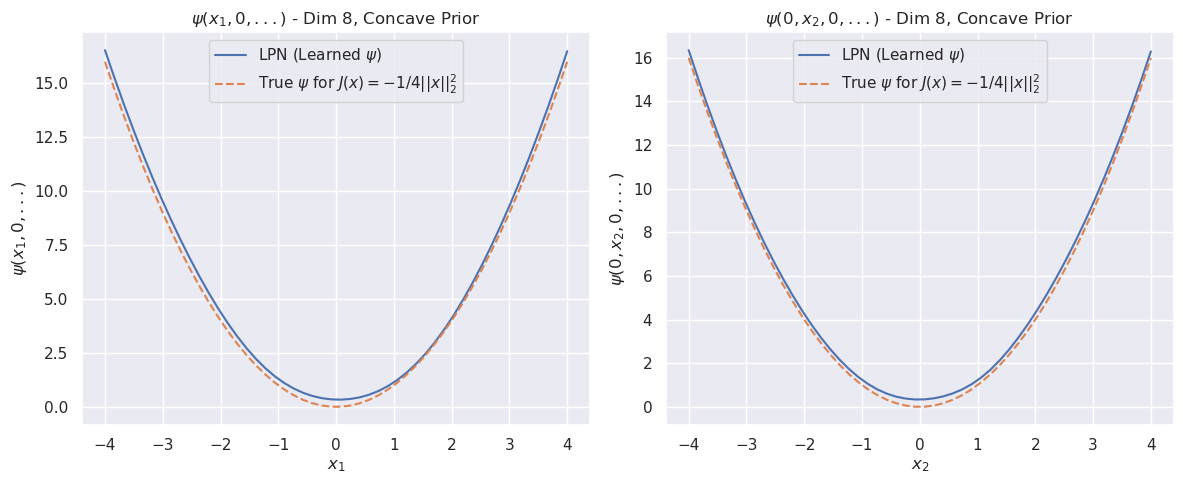

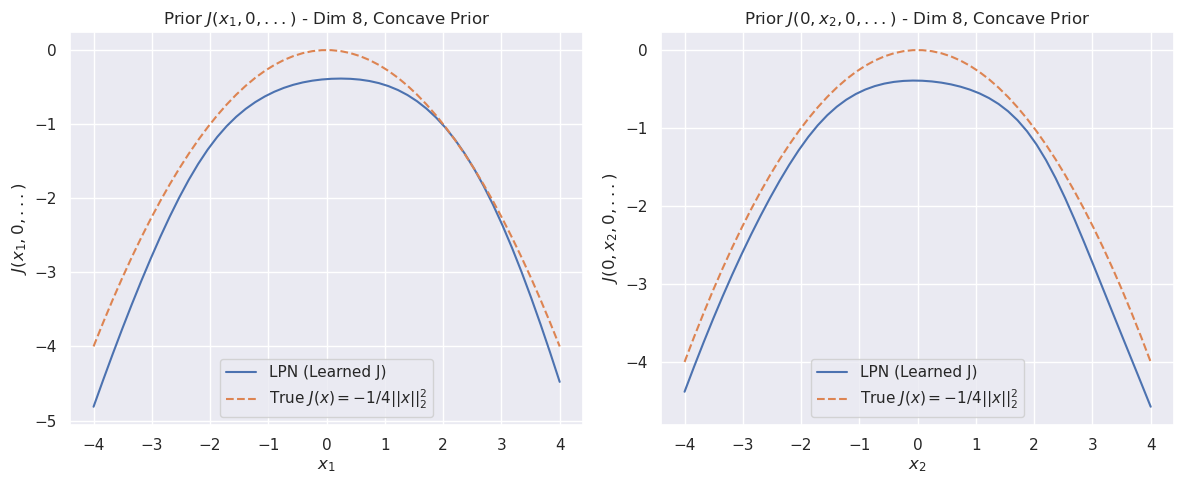

In [13]:
# --- Plot the results of the new experiment ---
plot_all_concave_quad(lpn_model_concave_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)
#evaluate_learned_H(lpn_model_concave_quad_l1, a_exp, spacing, dim_exp)

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Plotting Updated Prior j_hat(y) (Dim=8) ---


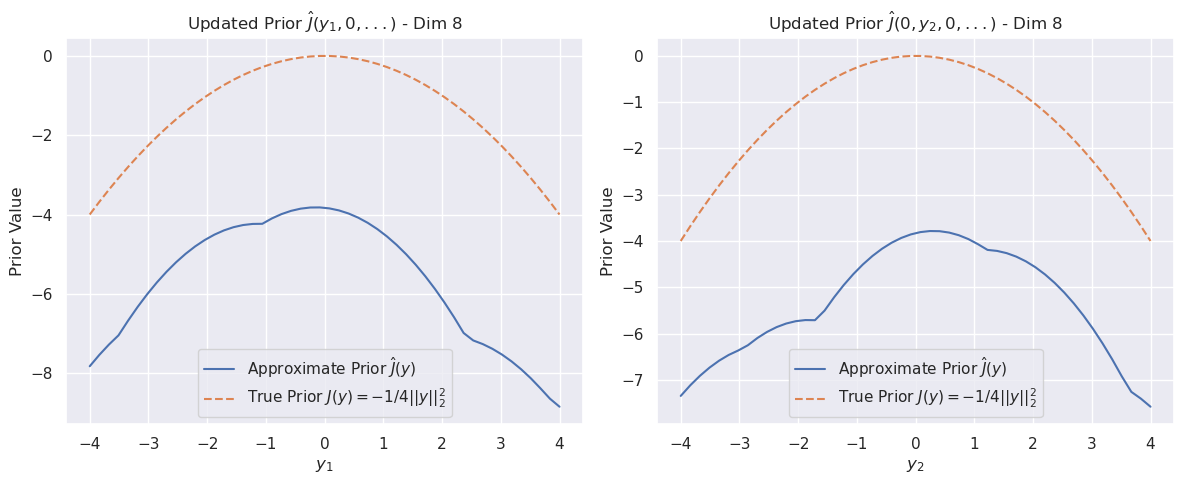

In [14]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = x_j_exp_tensor.clone()
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l1.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l1(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach() 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
    """
    Implements the approximate prior.
    """
    
    # Pre-compute y_k = grad psi(x_k) from the training data
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    y_k_tensor = model(x_k_tensor)
    y_k_np = y_k_tensor.detach().cpu().numpy()
    
    # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
    S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
    S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
    # The constant term simplifies to just S(x_k, 1)
    # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
    #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
    #        = S(x_k, 1)
    constants_k = S_x_k_np  # Shape (K,)
    
    # Term 3: -1/2 * ||x_k - y||^2
    # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
    term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
    # Term 4: 1/4 * ||y - y_k||^2
    # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
    term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

    term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
    all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
    # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
    # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
    # Take the max over K dimension
    j_hat_est = np.max(all_terms, axis=0)
    
    return j_hat_est

def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
    """
    Generates cross-section plots for the prior j_hat(y) from the "Update".
    """
    print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
    xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute true prior J(y)
    y1_0_J_true = prior_true_concave_quad(y1_0_points)
    
    # Compute estimated prior j_hat(y)
    y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
    plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
    plt.grid(True)
    plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
    plt.xlabel('$y_1$')
    plt.ylabel('Prior Value')
    plt.legend()

    if dim > 1:
        y2_0_J_true = prior_true_concave_quad(y2_0_points)
        y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
        plt.subplot(1, 2, 2)
        plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
        plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
        plt.grid(True)
        plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
        plt.xlabel('$y_2$')
        plt.ylabel('Prior Value')
        plt.legend()
        
    plt.tight_layout()
    plt.show()


# We use the original training data 'x_j_exp_np' as our set of x_k points.
#subset_size = 1000 
x_k_subset_np = x_j_exp_np#[:subset_size, :]

plot_updated_prior_J_hat(lpn_model_concave_quad, a_exp, spacing, dim_exp, x_k_subset_np)


In [15]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 2091.30908203125


iteration 0 loss 45.20343780517578


iteration 5000 loss 36.286685943603516


iteration 10000 loss 0.196733757853508


iteration 15000 loss 0.06818181276321411


iteration 20000 loss 0.0479758195579052


iteration 25000 loss 0.0382491759955883


iteration 30000 loss 0.033311255276203156


iteration 35000 loss 0.029944857582449913


iteration 40000 loss 0.027354680001735687


iteration 45000 loss 0.02531115896999836


iteration 50000 loss 0.02363426238298416


iteration 55000 loss 0.022352168336510658


iteration 60000 loss 0.021239550784230232


iteration 65000 loss 0.020336143672466278


iteration 70000 loss 0.019410720095038414


iteration 75000 loss 0.018627716228365898


iteration 80000 loss 0.01798957772552967


iteration 85000 loss 0.01731923595070839


iteration 90000 loss 0.016736812889575958


iteration 95000 loss 0.016208946704864502


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


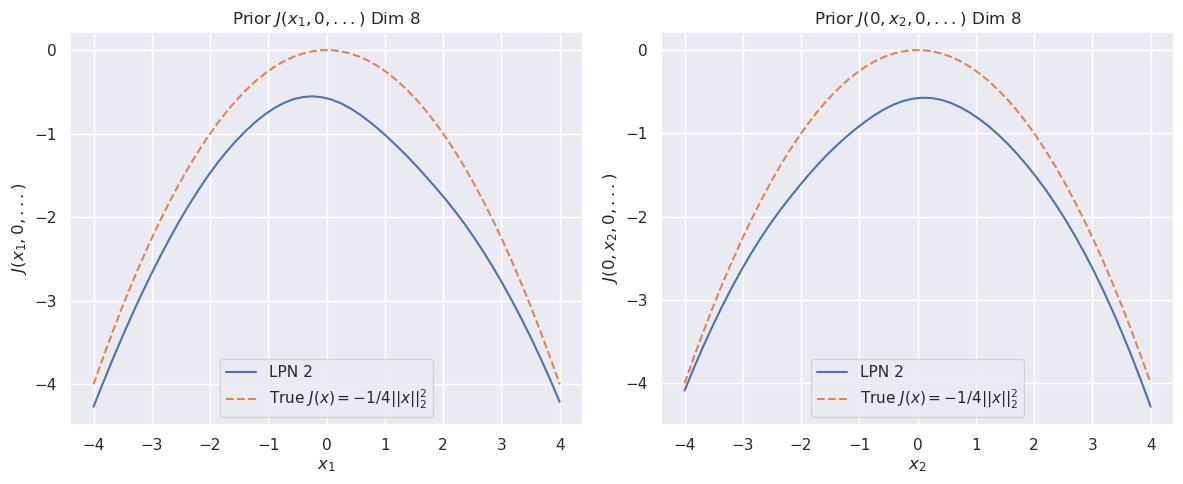

In [16]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)